In [1]:
# Import necessary libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
import joblib
from sklearn.preprocessing import StandardScaler
import mlflow

# Append parent directory to system path
sys.path.append('..')

In [2]:
# Load the best traditional model
best_model = joblib.load('../models/best_model_Gradient Boosting.joblib')

# Load the test data
print("Loading test dataset...")
test_data = pd.read_csv('../data/processed/test_data.csv')
display(test_data.head())

Loading test dataset...


,user_id,purchase_value,age,ip_address,time_diff,ip_int,hour_of_day,day_of_week,is_weekend,month,...,user_std_purchase,user_max_purchase,user_min_purchase,user_time_range_days,tx_velocity,source_encoded,browser_encoded,sex_encoded,country_encoded,class
0,171751,0.385567,0.563874,3.961405e+09,2682.805278,3961404649,10,2,0,9,...,NaN,0.385567,0.385567,0.0,0.0,0,3,1,181,0
1,43967,0.494721,0.447833,3.150281e+09,2839.298056,3150281030,5,4,0,9,...,NaN,0.494721,0.494721,0.0,0.0,2,3,1,107,0
2,218957,-0.269358,0.331793,2.035115e+07,1428.988333,20351151,18,1,0,7,...,NaN,-0.269358,-0.269358,0.0,0.0,0,0,0,176,1
3,377211,-0.651398,-0.944649,3.568979e+09,1747.151389,3568979293,11,0,0,5,...,NaN,-0.651398,-0.651398,0.0,0.0,2,1,1,8,0
4,225557,0.658452,1.028034,4.971851e+08,2717.191111,497185119,11,1,0,9,...,NaN,0.658452,0.658452,0.0,0.0,1,0,1,171,0


In [3]:
# Prepare features
X_test = test_data.drop('class', axis=1)
y_test = test_data['class']

In [4]:
# Select numeric columns and drop problematic ones
numeric_columns = X_test.select_dtypes(include=[np.number]).columns
X_test = X_test[numeric_columns]
X_test = X_test.drop('user_std_purchase', axis=1)


In [5]:
# Scale the features
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [6]:
# SHAP Analysis
print("\nGenerating SHAP explanations...")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)



Generating SHAP explanations...


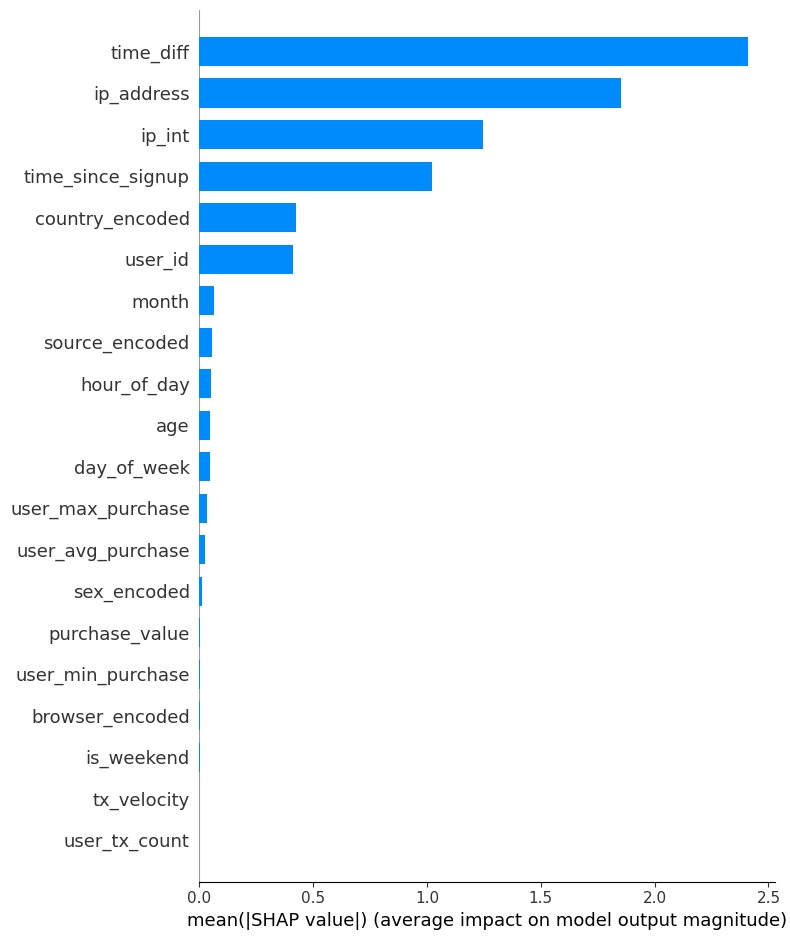

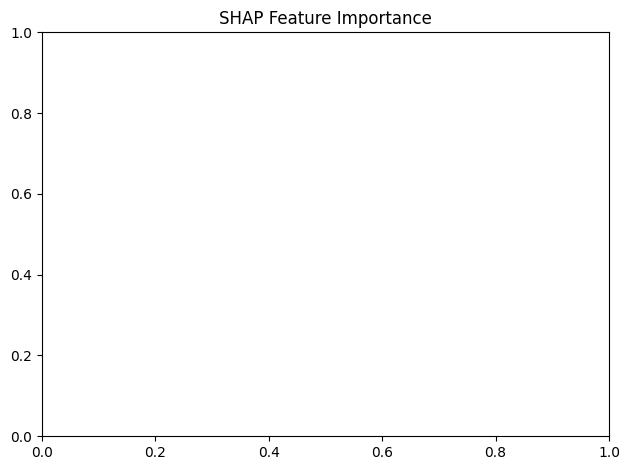

In [7]:
# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.savefig('../reports/figures/shap_feature_importance.png')
plt.show()
plt.close()

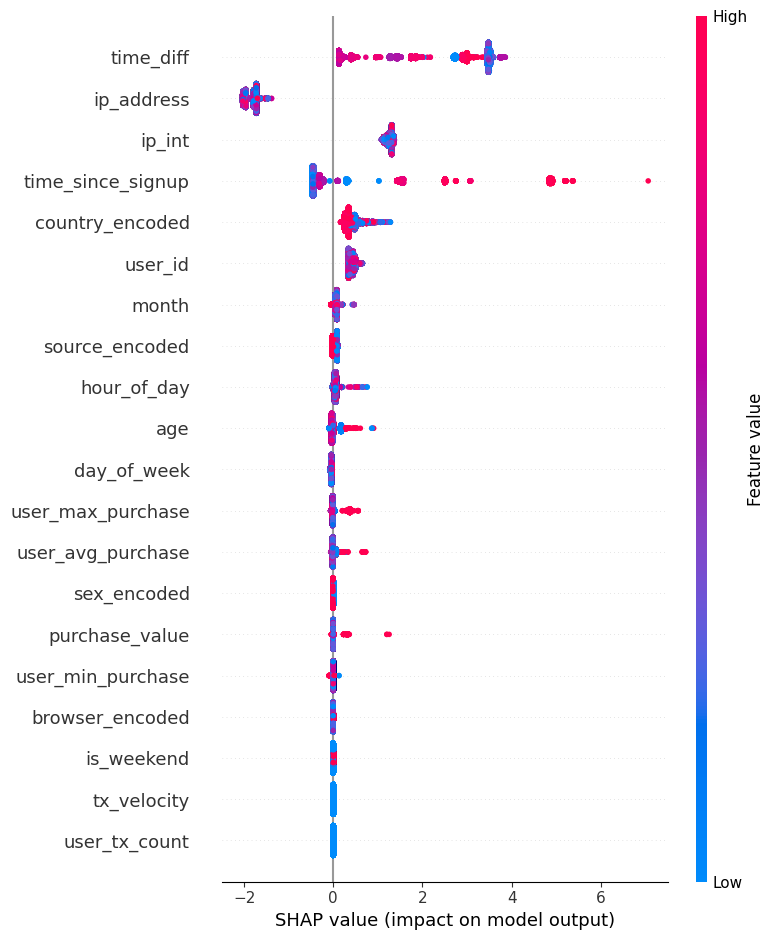

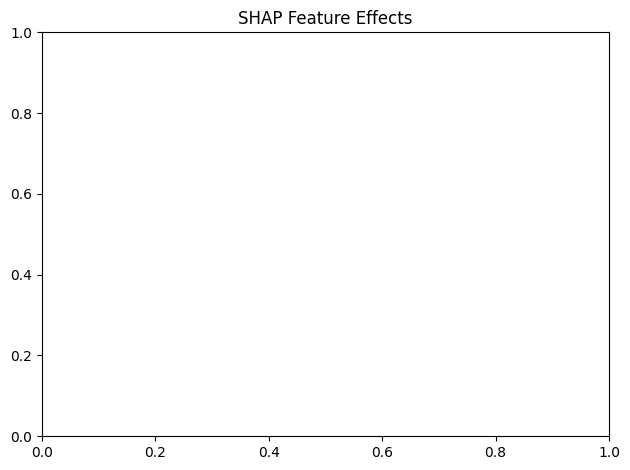

In [8]:
# SHAP Summary Plot (with feature effects)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled_df)
plt.title("SHAP Feature Effects")
plt.tight_layout()
plt.show()
plt.savefig('../reports/figures/shap_feature_effects.png')
plt.close()


Generating SHAP dependence plots...


<Figure size 1000x600 with 0 Axes>

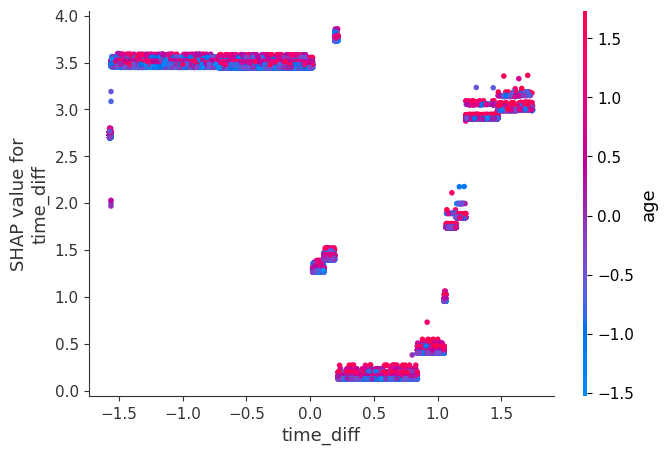

<Figure size 1000x600 with 0 Axes>

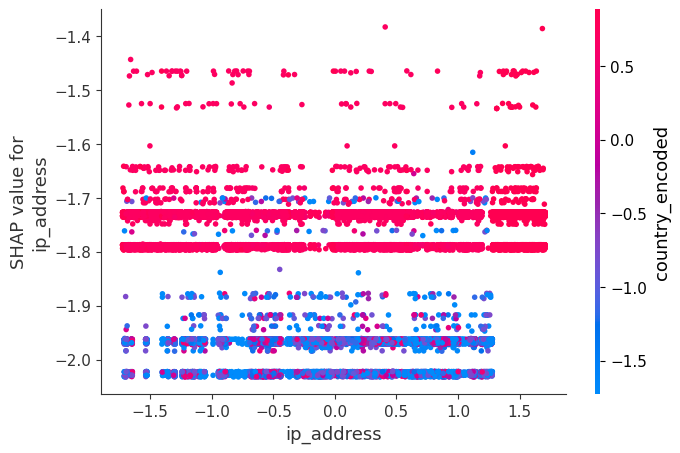

<Figure size 1000x600 with 0 Axes>

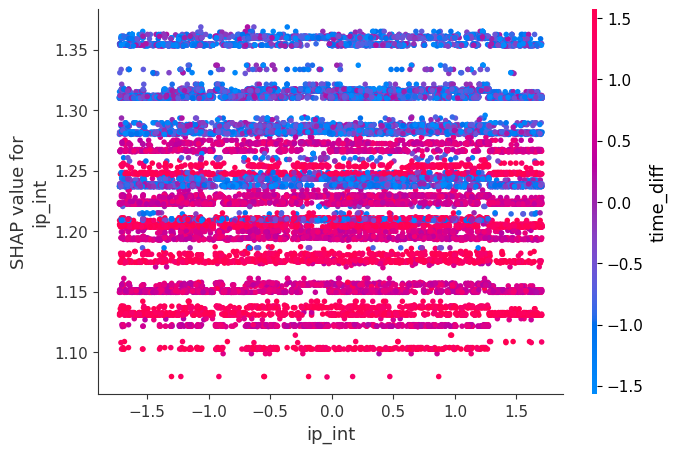

<Figure size 1000x600 with 0 Axes>

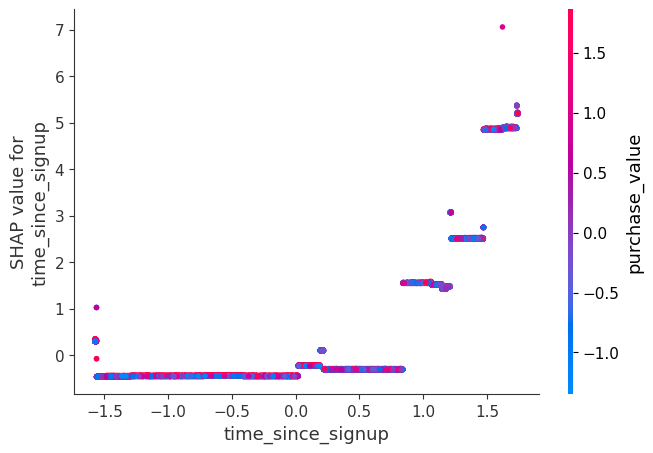

<Figure size 1000x600 with 0 Axes>

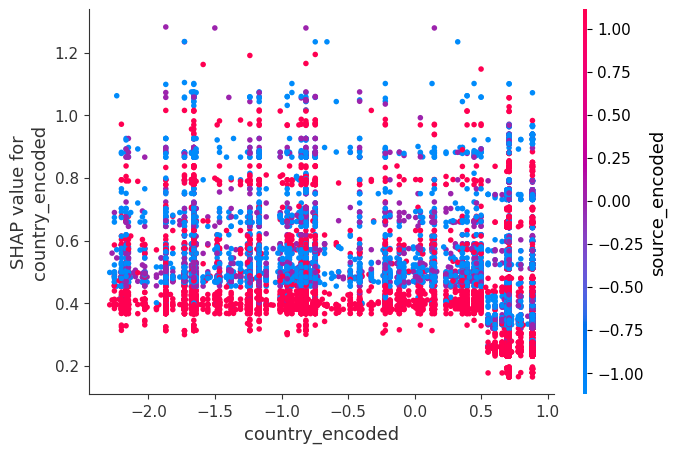

In [9]:
# SHAP Dependence Plots for top features
print("\nGenerating SHAP dependence plots...")
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(0)
})
top_features = feature_importance.nlargest(5, 'importance')['feature']

for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values, X_test_scaled_df)
    plt.title(f"SHAP Dependence Plot - {feature}")
    plt.tight_layout()
    plt.savefig(f'../reports/figures/shap_dependence_{feature}.png')
    plt.close()


Generating LIME explanations...


c:\Users\hp\Documents\FraudDetectionAI\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

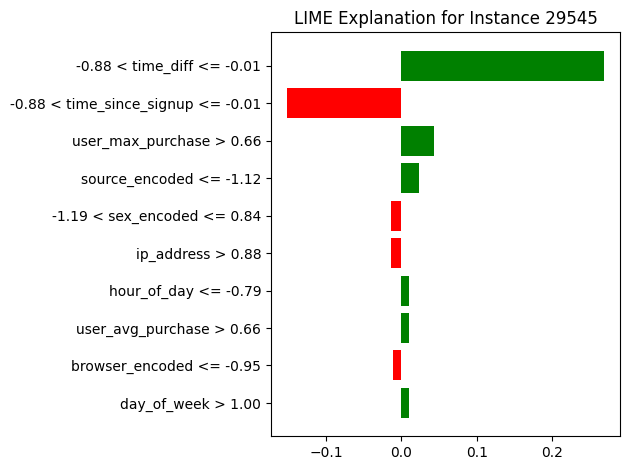

c:\Users\hp\Documents\FraudDetectionAI\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

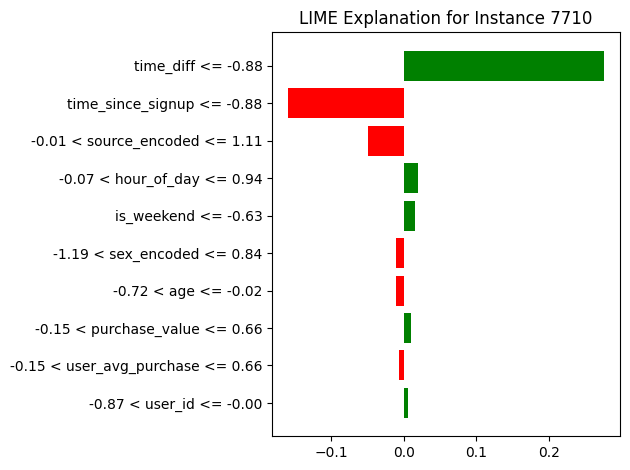

c:\Users\hp\Documents\FraudDetectionAI\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

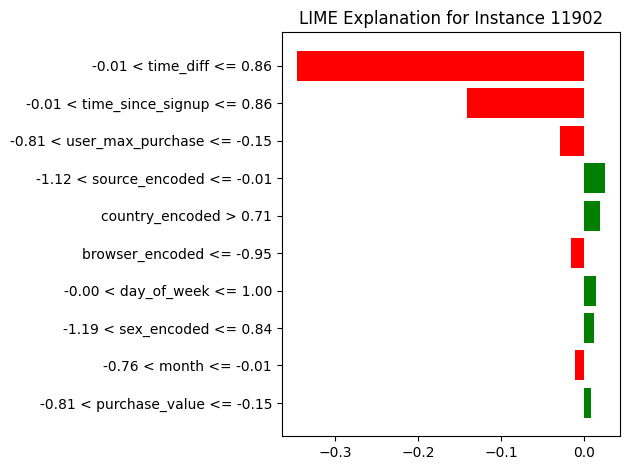

c:\Users\hp\Documents\FraudDetectionAI\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

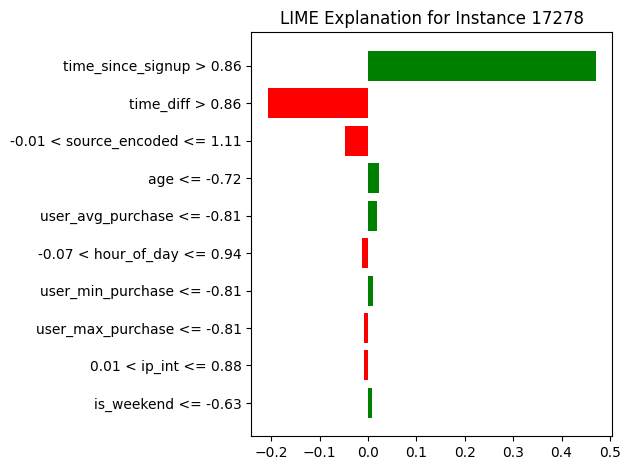

c:\Users\hp\Documents\FraudDetectionAI\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

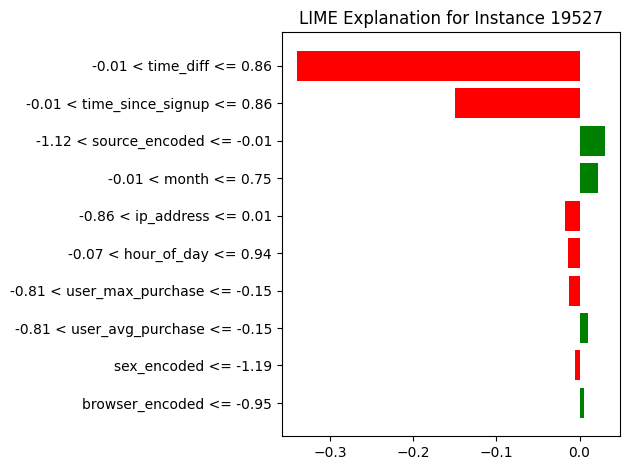

In [12]:
# LIME Analysis
print("\nGenerating LIME explanations...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_test_scaled,
    feature_names=X_test.columns,
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

# Generate LIME explanation for a sample of predictions
n_samples = 5
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

for idx in sample_indices:
    exp = lime_explainer.explain_instance(
        X_test_scaled[idx], 
        best_model.predict_proba,
        num_features=10
    )
    # Plot LIME explanation
    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for Instance {idx}")
    plt.tight_layout()
    plt.savefig(f'../reports/figures/lime_explanation_{idx}.png')
    plt.show()
    plt.close()

In [13]:
# Generate summary of explanations
print("\nModel Explainability Summary:")
print("\nTop 10 Most Important Features (SHAP):")
print(feature_importance.nlargest(10, 'importance'))


Model Explainability Summary:

Top 10 Most Important Features (SHAP):
              feature  importance
4           time_diff    2.408997
3          ip_address    1.850017
5              ip_int    1.247694
10  time_since_signup    1.021144
20    country_encoded    0.423033
0             user_id    0.408962
9               month    0.063925
17     source_encoded    0.054540
6         hour_of_day    0.049425
2                 age    0.045421


In [14]:
# Save feature importance to CSV
feature_importance.to_csv('../reports/feature_importance.csv', index=False)
display(feature_importance)

,feature,importance
0,user_id,0.408962
1,purchase_value,0.003939
2,age,0.045421
3,ip_address,1.850017
4,time_diff,2.408997
5,ip_int,1.247694
6,hour_of_day,0.049425
7,day_of_week,0.044284
8,is_weekend,0.001117
9,month,0.063925


In [15]:
# Log results to MLflow
with mlflow.start_run(run_name="model_explainability"):
    # Log feature importance plot
    mlflow.log_artifact('../reports/figures/shap_feature_importance.png')
    mlflow.log_artifact('../reports/figures/shap_feature_effects.png')
    
    # Log feature importance metrics
    for idx, row in feature_importance.iterrows():
        mlflow.log_metric(f"feature_importance_{row['feature']}", row['importance'])

print("\nExplanation plots have been saved to the reports/figures directory")
print("Feature importance has been saved to reports/feature_importance.csv")


Explanation plots have been saved to the reports/figures directory
Feature importance has been saved to reports/feature_importance.csv
